1. Data Collection and Preparation

In [100]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [101]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [102]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from tqdm import tqdm  # For progress tracking


In [104]:
def parse_review_file(file_path, category_name):
    """
    Parse Amazon reviews from a text file into a structured DataFrame for sentiment analysis.
    
    Args:
        file_path (str): Path to the text file containing Amazon reviews
        
    Returns:
        pd.DataFrame: Structured review data
    """
    reviews = []
    current_review = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            
            # Check if line is empty
            if not line:
                # End of a review record
                if current_review:
                    reviews.append(current_review)
                    current_review = {}
                continue
                
            # Process line if it contains a field
            if ':' in line:
                key, value = line.split(':', 1)
                current_review[key.strip()] = value.strip()
    # Add the last review if there is one
    if current_review:
        reviews.append(current_review)
    
    # Convert to DataFrame
    df = pd.DataFrame(reviews)
    # Clean column names
    df.columns = [col.split('/')[-1] if '/' in col else col for col in df.columns]

     # Add category column
    df['category'] = category_name
    
    # Convert numeric columns
    if 'score' in df.columns:
        df['score'] = pd.to_numeric(df['score'], errors='coerce')
    
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'].astype(float), unit='s')
        
    if 'helpfulness' in df.columns:
        # Split helpfulness into numerator and denominator
        df['helpfulness_numerator'] = df['helpfulness'].apply(
            lambda x: int(x.split('/')[0]) if isinstance(x, str) and '/' in x else None
        )
        df['helpfulness_denominator'] = df['helpfulness'].apply(
            lambda x: int(x.split('/')[1]) if isinstance(x, str) and '/' in x else None
        )

    # Remove unwanted columns
    columns_to_remove = ['time', 'profile name', 'userId']
    for col in columns_to_remove:
        if col in df.columns:
            df = df.drop(col, axis=1)
        
    return df

        

In [105]:
reviews_df = parse_review_file("Electronics.txt" , "Electronics")

In [106]:
import pandas as pd
import numpy as np

# Load your dataset
# Replace 'your_data_file.csv' with your actual file path
df = reviews_df

# Method 1: Simple random sampling
sample_size = 10000  # Change this to your desired sample size
random_sample = df.sample(n=sample_size)  # random_state ensures reproducibility

# Method 2: Stratified sampling (if you have a 'sentiment' or similar column to stratify by)
# This ensures your sample has the same proportions of each sentiment class as the full dataset
def stratified_sample(data, strat_column, sample_size):
    # Calculate the fraction to sample from each group
    fraction = sample_size / len(data)
    # Return a stratified sample
    return data.groupby(strat_column, group_keys=False).apply(
        lambda x: x.sample(frac=fraction, random_state=42))

# If you have a column named 'sentiment' or 'label' for stratification
if 'sentiment' in df.columns:
    stratified_sample = stratified_sample(df, 'sentiment', sample_size)

# Save your sampled data
random_sample.to_csv('sample_data.csv', index=False)

In [107]:
# Read the CSV file
reviews_df = pd.read_csv('sample_data.csv')

In [108]:
reviews_df.head()

,productId,title,price,profileName,helpfulness,score,summary,text,category,helpfulness_numerator,helpfulness_denominator
0,B000PCBVA6,TomTom ONE XL 4.3-Inch Bluetooth Portable GPS ...,unknown,Larry Masters,1/1,5.0,TOMTOM ONE XL,Was unsure of the reliability of tomtom until ...,Electronics,1,1
1,B000OSEVF8,"Sony DVP-FX810/R 8-Inch Portable DVD Player, C...",unknown,Savvy Shopper,8/9,2.0,Do not buy - not loud enough for a plane trip !,Before buying this unit I read all the reviews...,Electronics,8,9
2,B000AP05BO,Bose QuietComfort 2 Acoustic Noise Canceling H...,unknown,"V. Zapata ""Varlin""",1/2,2.0,Does not cancel enough for my expectations,I bought these on the hope I would work much b...,Electronics,1,2
3,B00002N602,Stainless Steel Pressure Cooker,29.95,"Ollie J. Smith ""great buyer""",0/3,5.0,great,been looking for one at a good price for dont ...,Electronics,0,3
4,B000ET9ZGC,Samsung YP-U2JZW 1 GB Direct Insert USB Digita...,unknown,"cgreenland ""cgreenland""",2/3,4.0,Good all around,"Great player, fantastic storage size vs. physi...",Electronics,2,3


In [109]:
reviews_df.shape

(10000, 11)

In [110]:
reviews_df.info

<bound method DataFrame.info of        productId                                              title    price  \
0     B000PCBVA6  TomTom ONE XL 4.3-Inch Bluetooth Portable GPS ...  unknown   
1     B000OSEVF8  Sony DVP-FX810/R 8-Inch Portable DVD Player, C...  unknown   
2     B000AP05BO  Bose QuietComfort 2 Acoustic Noise Canceling H...  unknown   
3     B00002N602                    Stainless Steel Pressure Cooker    29.95   
4     B000ET9ZGC  Samsung YP-U2JZW 1 GB Direct Insert USB Digita...  unknown   
...          ...                                                ...      ...   
9995  B0002SQ2P2  Logitech Z-2300 THX-Certified 2.1 Speaker Syst...  unknown   
9996  B00029MTMQ  Zalman Zm-Mic1 High Sensitivity Headphone Micr...     8.45   
9997  B000I1MHBQ      HP 20 Ink Cartridge in Retail Packaging-Black    27.49   
9998  B000051TI5  Labtec LCS-2424 Pulse 424 3-Piece Computer Spe...  unknown   
9999  B00074MZRU  Salton Beyond ePods Digital Video Camera & Por...  unknown   

       

# Count the number of each score in the data set

Score Distribution:
       Count  Percentage (%)
score                       
1.0     1318           13.18
2.0      623            6.23
3.0      811            8.11
4.0     2092           20.92
5.0     5156           51.56
Results saved to 'score_distribution.csv'


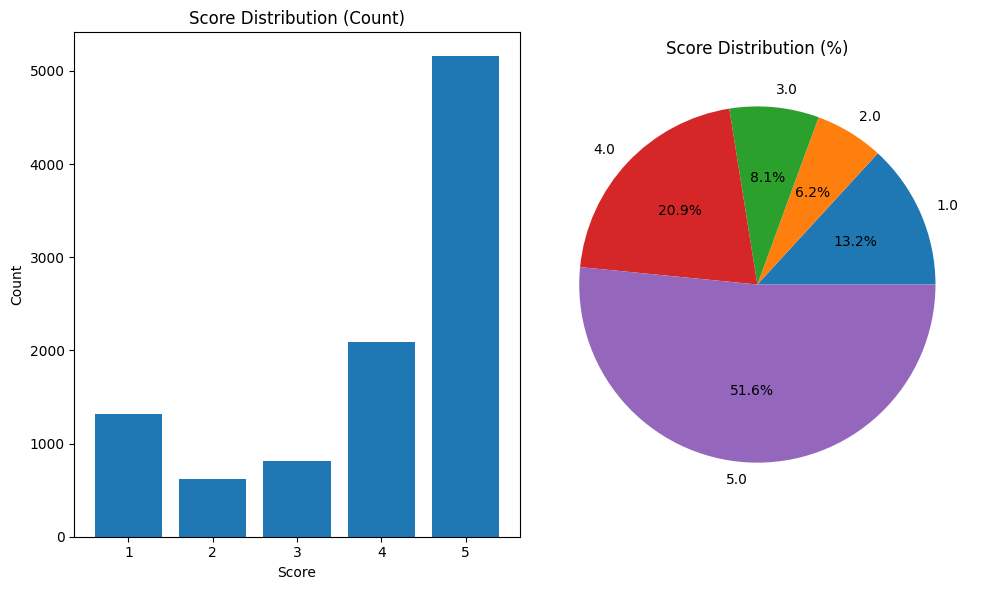

Visualization saved to 'score_distribution.png'


In [204]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming reviews_df is your dataframe and 'score' is your column name
# Replace 'score' with your actual column name if different

# Count occurrences of each score value
score_counts = reviews_df['score'].value_counts().sort_index()

# Calculate percentages
total_reviews = len(reviews_df)
score_percentages = (score_counts / total_reviews * 100).round(2)

# Create a dataframe with the results
results_df = pd.DataFrame({
    'Count': score_counts,
    'Percentage (%)': score_percentages
})

# Display the results
print("Score Distribution:")
print(results_df)

# Save to CSV
results_df.to_csv('score_distribution.csv')
print("Results saved to 'score_distribution.csv'")

# Create a visualization
plt.figure(figsize=(10, 6))

# Bar chart
ax1 = plt.subplot(121)
ax1.bar(score_counts.index, score_counts.values)
ax1.set_xlabel('Score')
ax1.set_ylabel('Count')
ax1.set_title('Score Distribution (Count)')
ax1.set_xticks(score_counts.index)

# Pie chart
ax2 = plt.subplot(122)
ax2.pie(score_counts.values, labels=score_counts.index, autopct='%1.1f%%')
ax2.set_title('Score Distribution (%)')

plt.tight_layout()
plt.savefig('score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to 'score_distribution.png'")

In [111]:
reviews_df['title'].unique()

array(['TomTom ONE XL 4.3-Inch Bluetooth Portable GPS Navigator',
       'Sony DVP-FX810/R 8-Inch Portable DVD Player, Cherry Red',
       'Bose QuietComfort 2 Acoustic Noise Canceling Headphones (Old Version)',
       ..., 'HP 20 Ink Cartridge in Retail Packaging-Black',
       'Labtec LCS-2424 Pulse 424 3-Piece Computer Speakers',
       'Salton Beyond ePods Digital Video Camera & Portable Entertainment System (Red)'],
      dtype=object)

In [216]:
count_review = reviews_df['productId'].value_counts().sort_index()
count_review.min()

1

In [112]:
# Print 5 random samples from the 'text' column
print("5 random review texts:")
for i, text in enumerate(reviews_df['text'].sample(5), 1):
    print(f"{i}. {text[:100]}..." if len(text) > 100 else f"{i}. {text}")

5 random review texts:
1. A worthwhile purchase. I bought this player initially for a flight from Los Angeles to Denver. It wo...
2. Bought this for my hard of hearing Dad and he loves it. He makes it to breakfast on time now.
3. Wow... I got this item in the mail about 12 days ago and i've been checking the price since then. It...
4. I like to play music -- mostly classical -- at my desk at work. This past week the volume control on...
5. This is a great suction cup mount. I've used it for numerous activities. I've mounted it to the outs...


2. Text Preprocessing
•	Convert text to lowercase
•	Remove special characters, HTML tags, URLs
•	Tokenize the text (break into words)
•	Remove stopwords (common words like "the", "and", etc.)
•	Apply lemmatization to reduce words to their base form
•	Handle negations (particularly important for sentiment analsis)


In [113]:
# Convert 'text' column to lowercase
reviews_df['text'] = reviews_df['text'].str.lower()

In [114]:
#Remove special characters, HTML tags, URLs
def clean_text(text):
    """
    Clean text by removing HTML tags, URLs, and special characters.
    
    Args:
        text (str): Text to clean
        
    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ""
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers, keeping only letters, spaces and basic punctuation
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


# Apply the cleaning function to create a new column
reviews_df['text_cleaned'] = reviews_df['text'].apply(clean_text)

In [115]:
# Check the first few rows to verify
print("First 5 cleaned review texts:")
for i, (original, cleaned) in enumerate(zip(reviews_df['text'].head(5), reviews_df['text_cleaned'].head(5)), 1):
    print(f"{i}. Original: {original[:50]}..." if len(original) > 50 else f"{i}. Original: {original}")
    print(f"   Cleaned:  {cleaned[:50]}..." if len(cleaned) > 50 else f"   Cleaned:  {cleaned}")
    print()

First 5 cleaned review texts:
1. Original: was unsure of the reliability of tomtom until i wa...
   Cleaned:  was unsure of the reliability of tomtom until i wa...

2. Original: before buying this unit i read all the reviews say...
   Cleaned:  before buying this unit i read all the reviews say...

3. Original: i bought these on the hope i would work much bette...
   Cleaned:  i bought these on the hope i would work much bette...

4. Original: been looking for one at a good price for dont laug...
   Cleaned:  been looking for one at a good price for dont laug...

5. Original: great player, fantastic storage size vs. physical ...
   Cleaned:  great player, fantastic storage size vs. physical ...



In [116]:
#Tokenize the text (break into words)
def tokenize_text(text):
    """
    Tokenize text into individual words.
    
    Args:
        text (str): Text to tokenize
        
    Returns:
        list: List of tokens (words)
    """
    if not isinstance(text,str):
        return[]


    #Tokenize the text into word
    tokens = word_tokenize(text)
    return tokens

#Apply tokenization to the cleaned text
reviews_df['tokens'] = reviews_df['text_cleaned'].apply(tokenize_text)
    
# Check the first few rows to verify
print("First 5 tokenized reviews:")
for i, tokens in enumerate(reviews_df['tokens'].head(5), 1):
    print(f"{i}. {tokens[:15]}..." if len(tokens) > 15 else f"{i}. {tokens}")

First 5 tokenized reviews:
1. ['was', 'unsure', 'of', 'the', 'reliability', 'of', 'tomtom', 'until', 'i', 'was', 'in', 'los', 'angleslong', 'beach', 'area']...
2. ['before', 'buying', 'this', 'unit', 'i', 'read', 'all', 'the', 'reviews', 'saying', 'the', 'speakers', 'were', 'not', 'loud']...
3. ['i', 'bought', 'these', 'on', 'the', 'hope', 'i', 'would', 'work', 'much', 'better', 'even', 'with', 'my', 'children']...
4. ['been', 'looking', 'for', 'one', 'at', 'a', 'good', 'price', 'for', 'dont', 'laugh', 'seven', 'years', 'very', 'conservative']...
5. ['great', 'player', ',', 'fantastic', 'storage', 'size', 'vs.', 'physical', 'size', ',', 'and', 'the', 'fm', 'radio', 'tuner']...


In [117]:
# Add token count column
reviews_df['token_count'] = reviews_df['tokens'].apply(len)

# Display statistics about token counts
print(f"Average tokens per review: {reviews_df['token_count'].mean():.2f}")
print(f"Min tokens: {reviews_df['token_count'].min()}")
print(f"Max tokens: {reviews_df['token_count'].max()}")

Average tokens per review: 115.26
Min tokens: 7
Max tokens: 2867


In [118]:
# remove stop words
def remove_stopwords(tokens):
    """
    Remove common stopwords from a list of tokens.
    
    Args:
        tokens (list): List of word tokens
        
    Returns:
        list: List of tokens with stopwords removed
    """
    # check if token is a list
    if not isinstance(tokens, list):
        return []
    #get English stop words 
    stop_words = set(stopwords.words('english'))
    # filter out the stop wprds
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

reviews_df['tokens_no_stopwords'] = reviews_df['tokens'].apply(remove_stopwords)
# Check the first few rows to compare before and after



In [119]:
reviews_df.head()

,productId,title,price,profileName,helpfulness,score,summary,text,category,helpfulness_numerator,helpfulness_denominator,text_cleaned,tokens,token_count,tokens_no_stopwords
0,B000PCBVA6,TomTom ONE XL 4.3-Inch Bluetooth Portable GPS ...,unknown,Larry Masters,1/1,5.0,TOMTOM ONE XL,was unsure of the reliability of tomtom until ...,Electronics,1,1,was unsure of the reliability of tomtom until ...,"[was, unsure, of, the, reliability, of, tomtom...",61,"[unsure, reliability, tomtom, los, angleslong,..."
1,B000OSEVF8,"Sony DVP-FX810/R 8-Inch Portable DVD Player, C...",unknown,Savvy Shopper,8/9,2.0,Do not buy - not loud enough for a plane trip !,before buying this unit i read all the reviews...,Electronics,8,9,before buying this unit i read all the reviews...,"[before, buying, this, unit, i, read, all, the...",364,"[buying, unit, read, reviews, saying, speakers..."
2,B000AP05BO,Bose QuietComfort 2 Acoustic Noise Canceling H...,unknown,"V. Zapata ""Varlin""",1/2,2.0,Does not cancel enough for my expectations,i bought these on the hope i would work much b...,Electronics,1,2,i bought these on the hope i would work much b...,"[i, bought, these, on, the, hope, i, would, wo...",110,"[bought, hope, would, work, much, better, even..."
3,B00002N602,Stainless Steel Pressure Cooker,29.95,"Ollie J. Smith ""great buyer""",0/3,5.0,great,been looking for one at a good price for dont ...,Electronics,0,3,been looking for one at a good price for dont ...,"[been, looking, for, one, at, a, good, price, ...",17,"[looking, one, good, price, dont, laugh, seven..."
4,B000ET9ZGC,Samsung YP-U2JZW 1 GB Direct Insert USB Digita...,unknown,"cgreenland ""cgreenland""",2/3,4.0,Good all around,"great player, fantastic storage size vs. physi...",Electronics,2,3,"great player, fantastic storage size vs. physi...","[great, player, ,, fantastic, storage, size, v...",88,"[great, player, ,, fantastic, storage, size, v..."


Lemmatization

In [120]:
from textblob import Word
from tqdm import tqdm

# Add progress bar
tqdm.pandas(desc="TextBlob lemmatizing")

# Apply lemmatization directly to each word in the list
reviews_df['textblob_lemmatized'] = reviews_df["tokens_no_stopwords"].progress_apply(
    lambda token_list: [Word(word).lemmatize() for word in token_list] if isinstance(token_list, list) else []
)

TextBlob lemmatizing: 100%|█████████████| 10000/10000 [00:02<00:00, 3684.79it/s]


In [121]:
reviews_df.head

<bound method NDFrame.head of        productId                                              title    price  \
0     B000PCBVA6  TomTom ONE XL 4.3-Inch Bluetooth Portable GPS ...  unknown   
1     B000OSEVF8  Sony DVP-FX810/R 8-Inch Portable DVD Player, C...  unknown   
2     B000AP05BO  Bose QuietComfort 2 Acoustic Noise Canceling H...  unknown   
3     B00002N602                    Stainless Steel Pressure Cooker    29.95   
4     B000ET9ZGC  Samsung YP-U2JZW 1 GB Direct Insert USB Digita...  unknown   
...          ...                                                ...      ...   
9995  B0002SQ2P2  Logitech Z-2300 THX-Certified 2.1 Speaker Syst...  unknown   
9996  B00029MTMQ  Zalman Zm-Mic1 High Sensitivity Headphone Micr...     8.45   
9997  B000I1MHBQ      HP 20 Ink Cartridge in Retail Packaging-Black    27.49   
9998  B000051TI5  Labtec LCS-2424 Pulse 424 3-Piece Computer Spe...  unknown   
9999  B00074MZRU  Salton Beyond ePods Digital Video Camera & Por...  unknown   

         

In [122]:
#Handle negations (particularly important for sentiment analysis)

def handle_negations(tokens):
    """
    Handle negations in tokens by appending 'NEG_ prefix to words following negation words
    untill a punctuation mark.
    Args:
        tokens (list): List of tokens
        
    Returns:
        list: List of tokens with negation handling
    """
    if not isinstance(tokens, list):
        return[]


    # Common negation words
    negation_words = {'not', 'no', 'never', 'none', 'neither', 'nor', 'nothing', 'nowhere', 'hardly', 'barely', 'scarcely', 'doesnt', 'isnt', 'wasnt', 'shouldnt', 'wouldnt', 'couldnt', 'wont', 'cant', 'dont', 'arent', 'aint', 'havent', 'hasnt', 'hadnt', 'didnt'}
    
    # Punctuation that ends negation scope
    punctuation = {'.', ',', ';', '!', '?', ':', '(', ')', '[', ']', '{', '}'}
    
    result = []
    negate = False
    for token in tokens:
        # Check if token is a negation word
        if token.lower() in negation_words:
            negate = True
            result.append(token)
        # Check if token is punctuation that ends negation scope
        elif token in punctuation:
            negate = False
            result.append(token)
        # Apply negation prefix if in negation scope
        elif negate:
            result.append('NEG_' + token)
        else:
            result.append(token)
    
    return result

# Apply negation handling to the lemmatized tokens
reviews_df['tokens_with_negation'] = reviews_df['textblob_lemmatized'].apply(handle_negations)



In [123]:
reviews_df.columns

Index(['productId', 'title', 'price', 'profileName', 'helpfulness', 'score',
       'summary', 'text', 'category', 'helpfulness_numerator',
       'helpfulness_denominator', 'text_cleaned', 'tokens', 'token_count',
       'tokens_no_stopwords', 'textblob_lemmatized', 'tokens_with_negation'],
      dtype='object')

VADER Sentiment Analysis

In [124]:
# import SentimentIntensityAnalyzer class from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
    print("VADER lexicon already downloaded")
except LookupError:
    print("Downloading VADER lexicon...")
    nltk.download('vader_lexicon')
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """
    Calculate VADER sentiment scores for text.
    Works with either strings or lists of tokens.
    """
    if isinstance(text, list):
        # Join list of tokens into a string
        text = ' '.join(text)
    elif not isinstance(text, str):
        # Return neutral sentiment if not string or list
        return {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
    
    # Return the sentiment scores
    return sid.polarity_scores(text)


# Function to get just the compound score (simplified)
def get_compound_sentiment(text):
    """Get just the compound sentiment score."""
    return get_vader_sentiment(text)['compound']

# Function to get sentiment category from compound score
def get_sentiment_category(compound):
    """Convert compound score to sentiment category."""
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'
# Add progress bar for pandas
tqdm.pandas(desc="Analyzing sentiment")

# Apply VADER sentiment analysis to the text column
# You can use either raw text or the lemmatized tokens
# Assuming 'text' column contains the original text
reviews_df['sentiment_scores'] = reviews_df['tokens_with_negation'].progress_apply(get_vader_sentiment)

# Extract individual sentiment components to separate columns
reviews_df['sentiment_neg'] = reviews_df['sentiment_scores'].apply(lambda x: x['neg'])
reviews_df['sentiment_neu'] = reviews_df['sentiment_scores'].apply(lambda x: x['neu'])
reviews_df['sentiment_pos'] = reviews_df['sentiment_scores'].apply(lambda x: x['pos'])
reviews_df['sentiment_compound'] = reviews_df['sentiment_scores'].apply(lambda x: x['compound'])

# Add a sentiment category column
reviews_df['sentiment_category'] = reviews_df['sentiment_compound'].apply(get_sentiment_category)


VADER lexicon already downloaded


Analyzing sentiment: 100%|██████████████| 10000/10000 [00:04<00:00, 2439.40it/s]


In [125]:
reviews_df.head

<bound method NDFrame.head of        productId                                              title    price  \
0     B000PCBVA6  TomTom ONE XL 4.3-Inch Bluetooth Portable GPS ...  unknown   
1     B000OSEVF8  Sony DVP-FX810/R 8-Inch Portable DVD Player, C...  unknown   
2     B000AP05BO  Bose QuietComfort 2 Acoustic Noise Canceling H...  unknown   
3     B00002N602                    Stainless Steel Pressure Cooker    29.95   
4     B000ET9ZGC  Samsung YP-U2JZW 1 GB Direct Insert USB Digita...  unknown   
...          ...                                                ...      ...   
9995  B0002SQ2P2  Logitech Z-2300 THX-Certified 2.1 Speaker Syst...  unknown   
9996  B00029MTMQ  Zalman Zm-Mic1 High Sensitivity Headphone Micr...     8.45   
9997  B000I1MHBQ      HP 20 Ink Cartridge in Retail Packaging-Black    27.49   
9998  B000051TI5  Labtec LCS-2424 Pulse 424 3-Piece Computer Spe...  unknown   
9999  B00074MZRU  Salton Beyond ePods Digital Video Camera & Por...  unknown   

         

TF-IDF Feature Extraction

For TF-IDF feature extraction, the best column to use would be text_cleaned since it contains 
the preprocessed text while maintaining the original structure. This is perfect for TF-IDF which
works best on complete text rather than already tokenized 
content.

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
# Create a directory to save the models
os.makedirs('models', exist_ok=True)

#Using text  _cleaned column for TF-IDF feature extraction
text_column = 'text_cleaned'

# Check for null values in our text column
null_count = reviews_df[text_column].isnull().sum()
print(f"\nNULL values in {text_column}:{null_count}") 





NULL values in text_cleaned:0


In [127]:
#prepare data for train test split
text_column = 'text_cleaned'
X = reviews_df[text_column]

# Using sentiment_category as target variable 
y = reviews_df['sentiment_category']
sentiment_counts = y.value_counts()


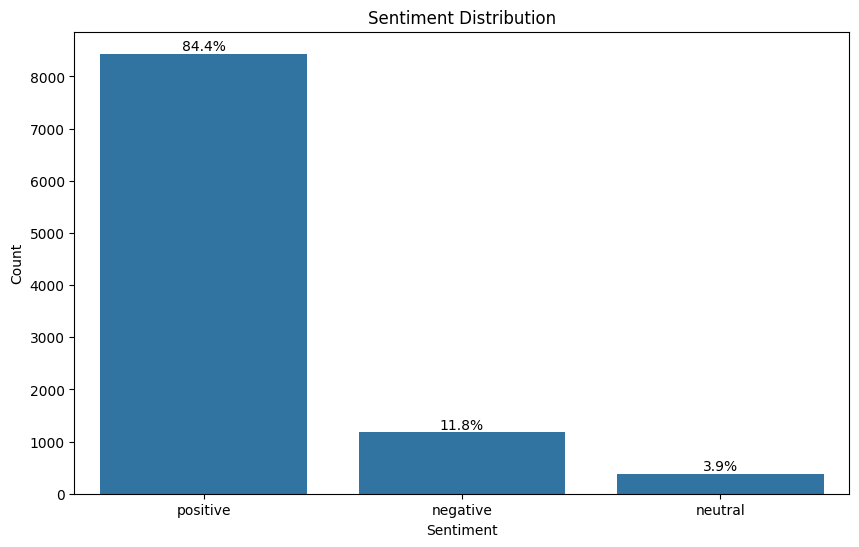

In [128]:
# Plot sentiment distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.ylabel('Count')
plt.xlabel('Sentiment')


# Add percentage labels
total = sum(sentiment_counts)
for i, p in enumerate(ax.patches):
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.show()

In [129]:
print("Sentiment distribution:")
for sentiment, count in sentiment_counts.items():
    print(f"  {sentiment}: {count} ({count/total:.2%})")

Sentiment distribution:
  positive: 8436 (84.36%)
  negative: 1179 (11.79%)
  neutral: 385 (3.85%)


In [130]:
# Split data with stratification to preserve sentiment distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Train set: 8000 samples
Test set: 2000 samples


In [131]:
tqdm.pandas()
# Initialize TF-IDF Vectorizer
print("\nInitializing TF-IDF Vectorizer...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,           # Limit features to 10,000 most frequent terms
    min_df=5,                     # Ignore terms that appear in less than 5 documents
    max_df=0.85,                  # Ignore terms that appear in more than 85% of documents
    ngram_range=(1, 2),           # Include unigrams and bigrams
    stop_words='english',         # Remove English stop words
    use_idf=True,                 # Use inverse document frequency
    norm='l2',                    # Apply L2 normalization
    smooth_idf=True               # Add 1 to document frequencies to prevent division by zero
)


Initializing TF-IDF Vectorizer...


In [132]:
# Fit the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Save the vectorizer and feature names
print("\nSaving TF-IDF vectorizer and features...")
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

feature_names = tfidf_vectorizer.get_feature_names_out()
with open('models/tfidf_feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)



Saving TF-IDF vectorizer and features...


In [133]:
# Save the train/test split indices and data
train_indices = X_train.index
test_indices = X_test.index
split_data = {
    'train_indices': train_indices.tolist(),
    'test_indices': test_indices.tolist(),
    'y_train': y_train.tolist(),
    'y_test': y_test.tolist()
}
with open('models/train_test_split_data.pkl', 'wb') as f:
    pickle.dump(split_data, f)

print("Vectorizer, features, and split data saved to 'models/' directory")

print("\nTop 20 features by overall TF-IDF score:")
mean_tfidf = X_train_tfidf.mean(axis=0).A.flatten()
top_indices = mean_tfidf.argsort()[-20:][::-1]
top_features = [(feature_names[i], mean_tfidf[i]) for i in top_indices]

# Create a DataFrame for better visualization
top_features_df = pd.DataFrame(top_features, columns=['Feature', 'TF-IDF Score'])
display(top_features_df)

Vectorizer, features, and split data saved to 'models/' directory

Top 20 features by overall TF-IDF score:


,Feature,TF-IDF Score
0,great,0.024416
1,good,0.020870
2,use,0.020271
3,product,0.019180
4,camera,0.018699
5,just,0.017509
6,like,0.015833
7,works,0.015550
8,sound,0.015524
9,price,0.014907


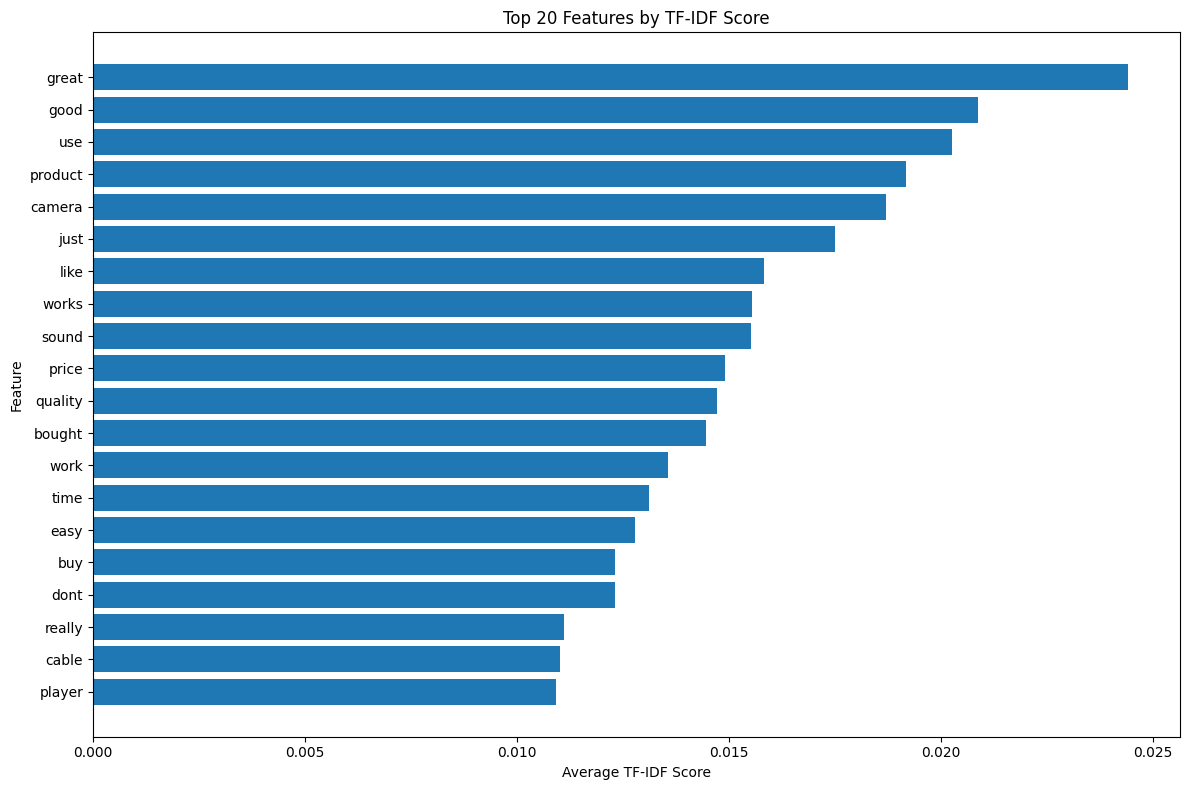

In [134]:
# Plot top features
plt.figure(figsize=(12, 8))
plt.barh(top_features_df['Feature'], top_features_df['TF-IDF Score'])
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Feature')
plt.title('Top 20 Features by TF-IDF Score')
plt.gca().invert_yaxis()  # To display highest score at the top
plt.tight_layout()
plt.show()


Top 10 features for 'negative' sentiment:

Top 10 features for 'neutral' sentiment:

Top 10 features for 'positive' sentiment:

Top features by sentiment category:

Top 10 features for 'negative' sentiment:


,Feature,TF-IDF Score
0,product,0.021287
1,problem,0.020962
2,time,0.017846
3,problems,0.016361
4,just,0.016031
5,work,0.015962
6,use,0.015881
7,buy,0.015507
8,got,0.015030
9,bought,0.014986



Top 10 features for 'positive' sentiment:


,Feature,TF-IDF Score
0,great,0.028422
1,good,0.023506
2,use,0.021182
3,camera,0.019797
4,product,0.018900
5,just,0.017844
6,like,0.017446
7,sound,0.016794
8,works,0.016400
9,price,0.016001



Top 10 features for 'neutral' sentiment:


,Feature,TF-IDF Score
0,work,0.024988
1,product,0.018869
2,cable,0.018849
3,works,0.015606
4,does,0.015152
5,used,0.015050
6,just,0.014692
7,use,0.013736
8,buy,0.013116
9,dont,0.012981


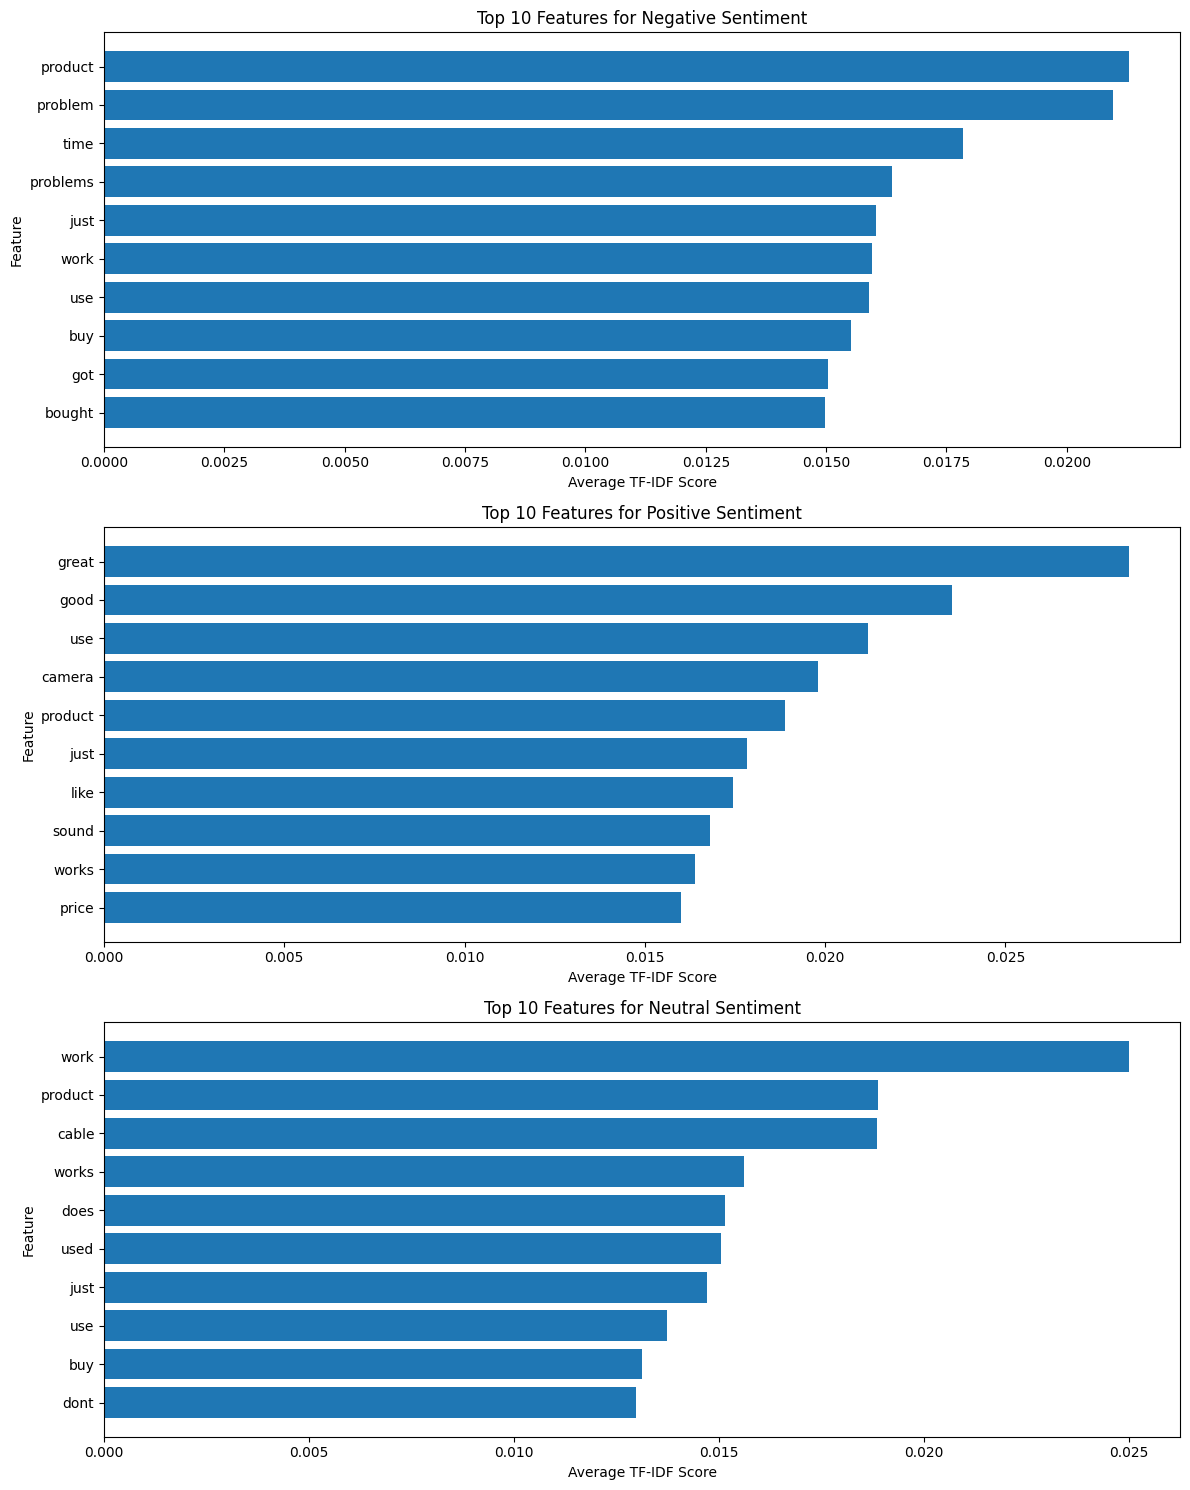

In [135]:
import numpy as np

# Define the categories for sentiment analysis
categories = ['negative', 'neutral', 'positive']  # Adjust these based on actual sentiment categories


# Convert train_indices to a NumPy array for fast searching
train_indices_array = np.array(train_indices)

# Iterate through sentiment categories
for i, category in enumerate(categories):
    print(f"\nTop 10 features for '{category}' sentiment:")
    
    # Get indices where category appears
    category_indices = y_train[y_train == category].index
    
    # Faster way to filter train indices
    category_indices_in_train = train_indices_array[np.isin(train_indices_array, category_indices)]

# Fixed code for analyzing features by category
print("\nTop features by sentiment category:")
categories = y_train.unique()

# Create a figure with subplots for each category
fig, axes = plt.subplots(len(categories), 1, figsize=(12, 5 * len(categories)))
if len(categories) == 1:
    axes = [axes]

for i, category in enumerate(categories):
    print(f"\nTop 10 features for '{category}' sentiment:")
    
    # Find samples in the train set with this category
    category_mask = y_train == category
    
    # Directly use the mask to select TF-IDF vectors
    category_tfidf = X_train_tfidf[category_mask]
    
    if category_tfidf.shape[0] > 0:
        # Calculate mean TF-IDF score for this category
        # Handle different return types (sparse or dense matrix)
        category_mean = category_tfidf.mean(axis=0)
        
        # Convert to a flat numpy array regardless of input type
        if hasattr(category_mean, 'toarray'):
            category_mean = category_mean.toarray().flatten()
        elif isinstance(category_mean, np.matrix):
            category_mean = np.asarray(category_mean).flatten()
        else:
            category_mean = np.array(category_mean).flatten()
        
        # Find top features
        cat_top_indices = category_mean.argsort()[-10:][::-1]
        cat_top_features = [(feature_names[i], category_mean[i]) for i in cat_top_indices]
        
        # Create a DataFrame for each category
        cat_features_df = pd.DataFrame(cat_top_features, columns=['Feature', 'TF-IDF Score'])
        display(cat_features_df)
        
        # Plot the features for this category
        axes[i].barh(cat_features_df['Feature'], cat_features_df['TF-IDF Score'])
        axes[i].set_xlabel('Average TF-IDF Score')
        axes[i].set_ylabel('Feature')
        axes[i].set_title(f'Top 10 Features for {category.capitalize()} Sentiment')
        axes[i].invert_yaxis()  # To display highest score at the top
    else:
        print(f"No samples found for category '{category}' in the training set")

plt.tight_layout()
plt.show()

In [136]:
# Save the TF-IDF matrices as sparse matrices
from scipy import sparse
sparse.save_npz('models/X_train_tfidf.npz', X_train_tfidf)
sparse.save_npz('models/X_test_tfidf.npz', X_test_tfidf)
print("TF-IDF matrices saved as sparse matrices")

print("\nTF-IDF feature extraction completed!")

TF-IDF matrices saved as sparse matrices

TF-IDF feature extraction completed!


Model Training and evaluation

In [137]:
# Model Training and Evaluation with TF-IDF Features
# Machine learning imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV


# Load saved TF-IDF data
print("Loading TF-IDF matrices and training data...")
X_train_tfidf = sparse.load_npz('models/X_train_tfidf.npz')
X_test_tfidf = sparse.load_npz('models/X_test_tfidf.npz')

# Load the train/test split data
with open('models/train_test_split_data.pkl', 'rb') as f:
    split_data = pickle.load(f)
    y_train = np.array(split_data['y_train'])
    y_test = np.array(split_data['y_test'])
    


print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Testing data shape: {X_test_tfidf.shape}")

# Create a directory to save trained models
os.makedirs('trained_models', exist_ok=True)




Loading TF-IDF matrices and training data...
Training data shape: (8000, 10000)
Testing data shape: (2000, 10000)


In [138]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return cm


# Function to evaluate and display model results
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n--- {model_name} Evaluation ---")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


 # Plot confusion matrix
    classes = np.unique(y_test)
    cm = plot_confusion_matrix(y_test, y_pred, classes, f'Confusion Matrix - {model_name}')
    
    # Return metrics for comparison
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'predictions': y_pred
    }

Logistic Regression

In [139]:
# First, train a basic model to get a baseline
print("Training baseline Logistic Regression...")
lr_baseline = LogisticRegression(max_iter=1000, random_state=42)
lr_baseline.fit(X_train_tfidf, y_train)



Training baseline Logistic Regression...


LogisticRegression(max_iter=1000, random_state=42)


--- Logistic Regression (Baseline) Evaluation ---
Accuracy: 0.8705

Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.25      0.39       236
     neutral       0.00      0.00      0.00        77
    positive       0.87      1.00      0.93      1687

    accuracy                           0.87      2000
   macro avg       0.58      0.42      0.44      2000
weighted avg       0.84      0.87      0.83      2000



/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

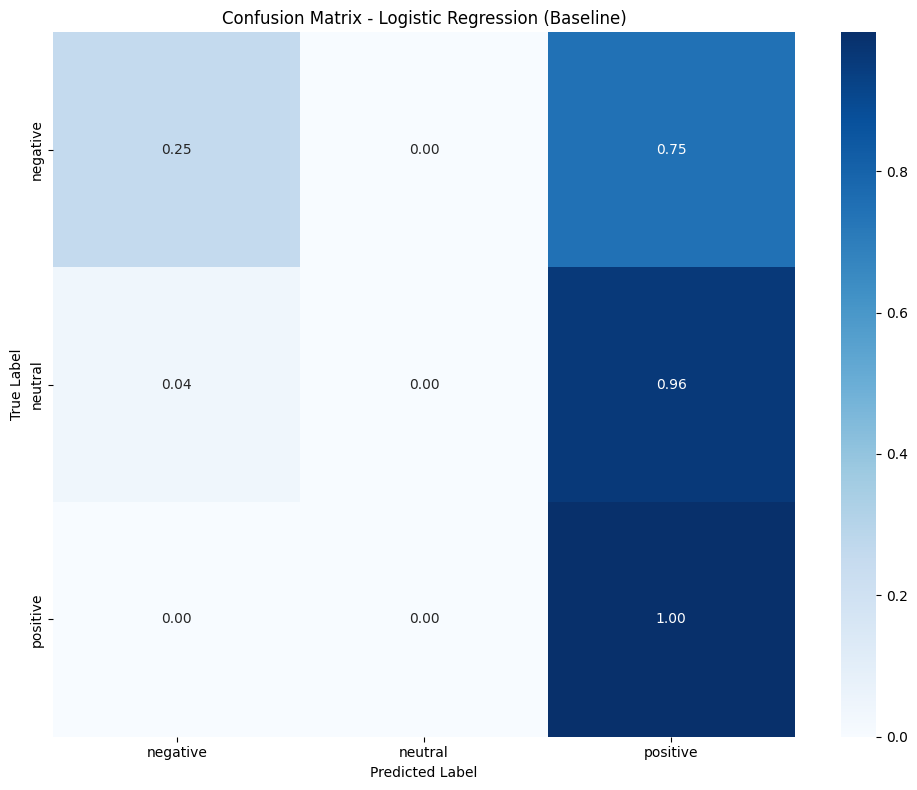

In [140]:
# Evaluate baseline model
baseline_results = evaluate_model(lr_baseline, X_test_tfidf, y_test, "Logistic Regression (Baseline)")

Optimize Logistic Regression Performance

In [141]:
# Fixed grid search for Logistic Regression
print("\nPerforming grid search for Logistic Regression hyperparameters...")

# Increase max_iter to avoid convergence warnings
max_iter_value = 2000  # Try a higher value

# Define valid parameter combinations as separate grids
param_grid_l1_saga = {
    'penalty': ['l1'],
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['saga'],
    'class_weight': [None, 'balanced']
}

param_grid_l2 = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['newton-cg', 'lbfgs', 'saga'],  # All valid solvers for l2
    'class_weight': [None, 'balanced']
}

param_grid_elasticnet = {
    'penalty': ['elasticnet'],
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['saga'],  # Only valid solver for elasticnet
    'l1_ratio': [0.2, 0.5, 0.8],  # Adding l1_ratio for elasticnet
    'class_weight': [None, 'balanced']
}

param_grid_none = {
    'penalty': [None],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # All valid solvers for no penalty
    'class_weight': [None, 'balanced']
}

# Run separate grid searches for each valid combination
# This will be cleaner and avoid warnings about invalid combinations

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# First grid search (l1 with saga)
lr_grid_l1 = GridSearchCV(
    LogisticRegression(max_iter=max_iter_value, random_state=42),
    param_grid=param_grid_l1_saga,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
lr_grid_l1.fit(X_train_tfidf, y_train)
print(f"Best l1 parameters: {lr_grid_l1.best_params_}")
print(f"Best l1 score: {lr_grid_l1.best_score_:.4f}")

# Second grid search (l2)
lr_grid_l2 = GridSearchCV(
    LogisticRegression(max_iter=max_iter_value, random_state=42),
    param_grid=param_grid_l2,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
lr_grid_l2.fit(X_train_tfidf, y_train)
print(f"Best l2 parameters: {lr_grid_l2.best_params_}")
print(f"Best l2 score: {lr_grid_l2.best_score_:.4f}")

# Compare all results to find the overall best
results = {
    'l1_saga': (lr_grid_l1.best_score_, lr_grid_l1.best_params_),
    'l2': (lr_grid_l2.best_score_, lr_grid_l2.best_params_)
    # Add more if you run the other grids
}

best_config = max(results.items(), key=lambda x: x[1][0])
print(f"\nOverall best configuration: {best_config[0]}")
print(f"Best parameters: {best_config[1][1]}")
print(f"Best score: {best_config[1][0]:.4f}")


Performing grid search for Logistic Regression hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best l1 parameters: {'C': 10.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Best l1 score: 0.8779
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anaconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best l2 parameters: {'C': 10.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Best l2 score: 0.8744

Overall best configuration: l1_saga
Best parameters: {'C': 10.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.8779


In [142]:
# Get the best model from your grid searches
if best_config[0] == 'l1_saga':
    best_lr_model = lr_grid_l1.best_estimator_
else:
    best_lr_model = lr_grid_l2.best_estimator_

# Train the best model on the training data
best_lr_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = best_lr_model.predict(X_test_tfidf)

# Calculate accuracy and other metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create the lr_results dictionary
lr_results = {}
lr_results['accuracy'] = accuracy_score(y_test, y_pred)
lr_results['report'] = classification_report(y_test, y_pred)
lr_results['confusion_matrix'] = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Logistic Regression (Tuned) Test Accuracy: {lr_results['accuracy']:.4f}")
print("\nClassification Report:")
print(lr_results['report'])
print("\nConfusion Matrix:")
print(lr_results['confusion_matrix'])

Logistic Regression (Tuned) Test Accuracy: 0.8895

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.58      0.62       236
     neutral       0.54      0.27      0.36        77
    positive       0.92      0.96      0.94      1687

    accuracy                           0.89      2000
   macro avg       0.71      0.60      0.64      2000
weighted avg       0.88      0.89      0.88      2000


Confusion Matrix:
[[ 136    8   92]
 [  12   21   44]
 [  55   10 1622]]


In [143]:
# Define lr_best based on your grid search results
if best_config[0] == 'l1_saga':
    lr_best = lr_grid_l1.best_estimator_
else:
    lr_best = lr_grid_l2.best_estimator_

# Now you can access lr_best.coef_
if hasattr(lr_best, 'coef_'):
    # For binary classification
    if len(lr_best.classes_) == 2:
        coefs = lr_best.coef_[0]

Random Forest 

Training baseline Random Forest...

--- Random Forest (Baseline) Evaluation ---
Accuracy: 0.8525

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.08      0.15       236
     neutral       1.00      0.01      0.03        77
    positive       0.85      1.00      0.92      1687

    accuracy                           0.85      2000
   macro avg       0.91      0.36      0.36      2000
weighted avg       0.86      0.85      0.79      2000



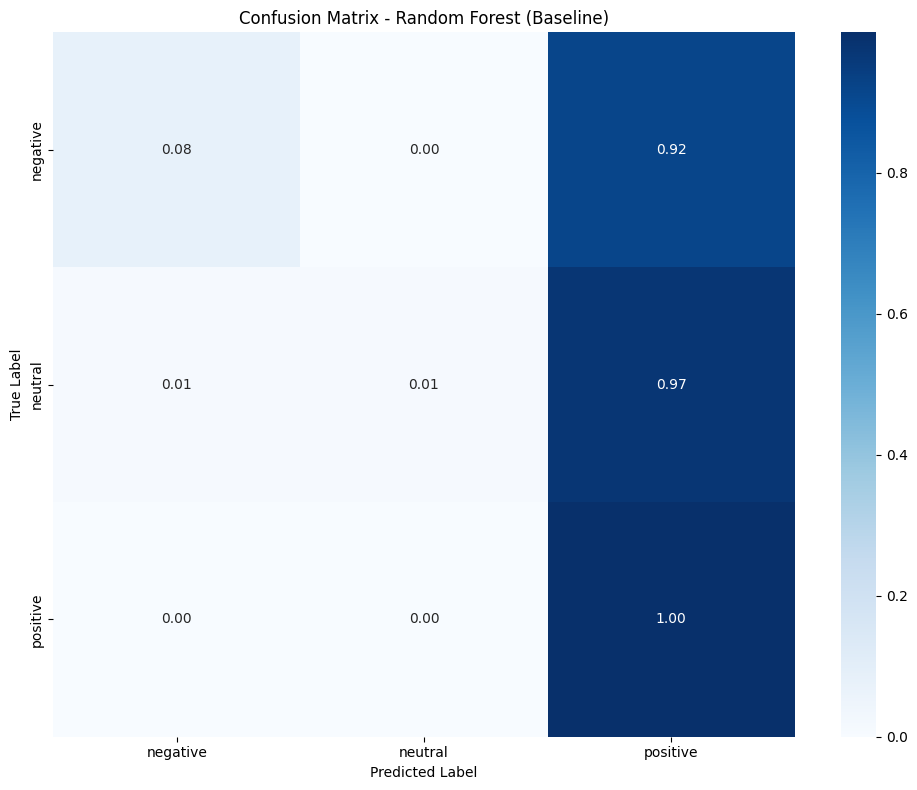


Performing grid search for Random Forest hyperparameters...


In [144]:
# Train a baseline Random Forest
print("Training baseline Random Forest...")
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
rf_baseline.fit(X_train_tfidf, y_train)

# Evaluate baseline model
rf_baseline_results = evaluate_model(rf_baseline, X_test_tfidf, y_test, "Random Forest (Baseline)")

# Grid search for hyperparameter tuning
print("\nPerforming grid search for Random Forest hyperparameters...")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score: 0.8610
Training Random Forest with best parameters...

--- Random Forest (Tuned) Evaluation ---
Accuracy: 0.8745

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.23      0.37       236
     neutral       0.55      0.29      0.38        77
    positive       0.88      0.99      0.93      1687

    accuracy                           0.87      2000
   macro avg       0.76      0.50      0.56      2000
weighted avg       0.87      0.87      0.85      2000



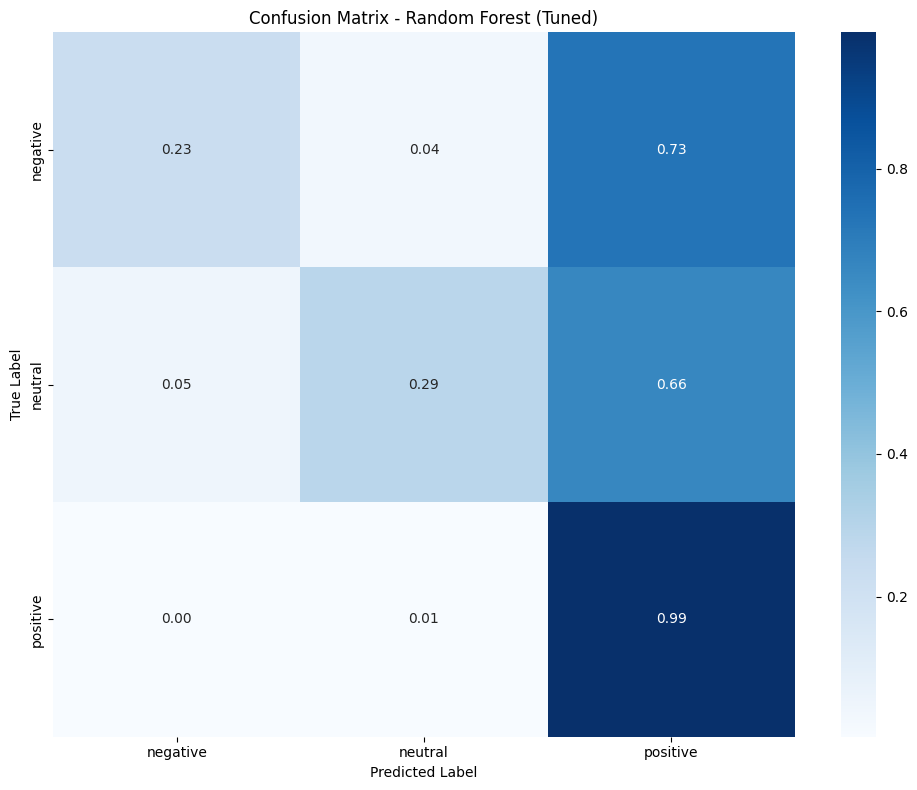

Random Forest model saved to 'trained_models/random_forest_model.pkl'


In [145]:
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_train_tfidf, y_train)

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

# Train the model with the best parameters
print("Training Random Forest with best parameters...")
rf_best = rf_grid.best_estimator_

# Evaluate the tuned model
rf_results = evaluate_model(rf_best, X_test_tfidf, y_test, "Random Forest (Tuned)")

# Save the model
with open('trained_models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_best, f)
print("Random Forest model saved to 'trained_models/random_forest_model.pkl'")



In [222]:
reviews_df.head()

,productId,title,price,profileName,helpfulness,score,summary,text,category,helpfulness_numerator,...,token_count,tokens_no_stopwords,textblob_lemmatized,tokens_with_negation,sentiment_scores,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,sentiment_category
0,B000PCBVA6,TomTom ONE XL 4.3-Inch Bluetooth Portable GPS ...,unknown,Larry Masters,1/1,5.0,TOMTOM ONE XL,was unsure of the reliability of tomtom until ...,Electronics,1,...,61,"[unsure, reliability, tomtom, los, angleslong,...","[unsure, reliability, tomtom, los, angleslong,...","[unsure, reliability, tomtom, los, angleslong,...","{'neg': 0.059, 'neu': 0.855, 'pos': 0.086, 'co...",0.059,0.855,0.086,0.2263,positive
1,B000OSEVF8,"Sony DVP-FX810/R 8-Inch Portable DVD Player, C...",unknown,Savvy Shopper,8/9,2.0,Do not buy - not loud enough for a plane trip !,before buying this unit i read all the reviews...,Electronics,8,...,364,"[buying, unit, read, reviews, saying, speakers...","[buying, unit, read, review, saying, speaker, ...","[buying, unit, read, review, saying, speaker, ...","{'neg': 0.137, 'neu': 0.706, 'pos': 0.157, 'co...",0.137,0.706,0.157,0.5584,positive
2,B000AP05BO,Bose QuietComfort 2 Acoustic Noise Canceling H...,unknown,"V. Zapata ""Varlin""",1/2,2.0,Does not cancel enough for my expectations,i bought these on the hope i would work much b...,Electronics,1,...,110,"[bought, hope, would, work, much, better, even...","[bought, hope, would, work, much, better, even...","[bought, hope, would, work, much, better, even...","{'neg': 0.14, 'neu': 0.655, 'pos': 0.205, 'com...",0.140,0.655,0.205,0.7845,positive
3,B00002N602,Stainless Steel Pressure Cooker,29.95,"Ollie J. Smith ""great buyer""",0/3,5.0,great,been looking for one at a good price for dont ...,Electronics,0,...,17,"[looking, one, good, price, dont, laugh, seven...","[looking, one, good, price, dont, laugh, seven...","[looking, one, good, price, dont, NEG_laugh, N...","{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp...",0.000,0.775,0.225,0.4404,positive
4,B000ET9ZGC,Samsung YP-U2JZW 1 GB Direct Insert USB Digita...,unknown,"cgreenland ""cgreenland""",2/3,4.0,Good all around,"great player, fantastic storage size vs. physi...",Electronics,2,...,88,"[great, player, ,, fantastic, storage, size, v...","[great, player, ,, fantastic, storage, size, v...","[great, player, ,, fantastic, storage, size, v...","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.000,0.806,0.194,0.9186,positive


Model Comparison 

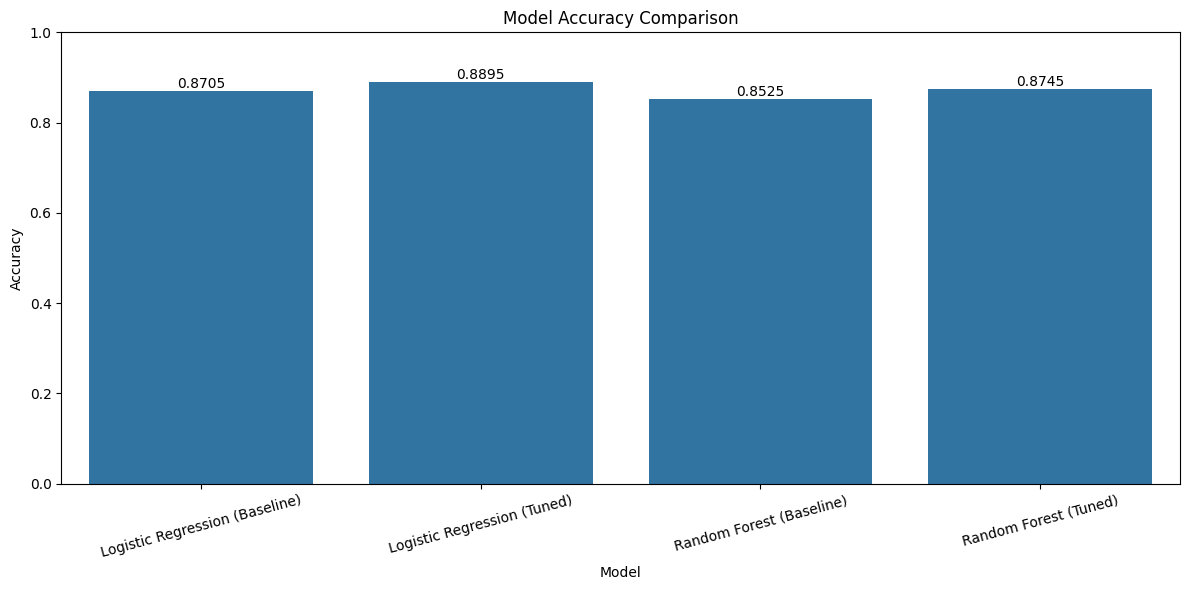


Model Comparison:
                            Model  Accuracy
1     Logistic Regression (Tuned)    0.8895
3           Random Forest (Tuned)    0.8745
0  Logistic Regression (Baseline)    0.8705
2        Random Forest (Baseline)    0.8525

Logistic Regression Coefficients:


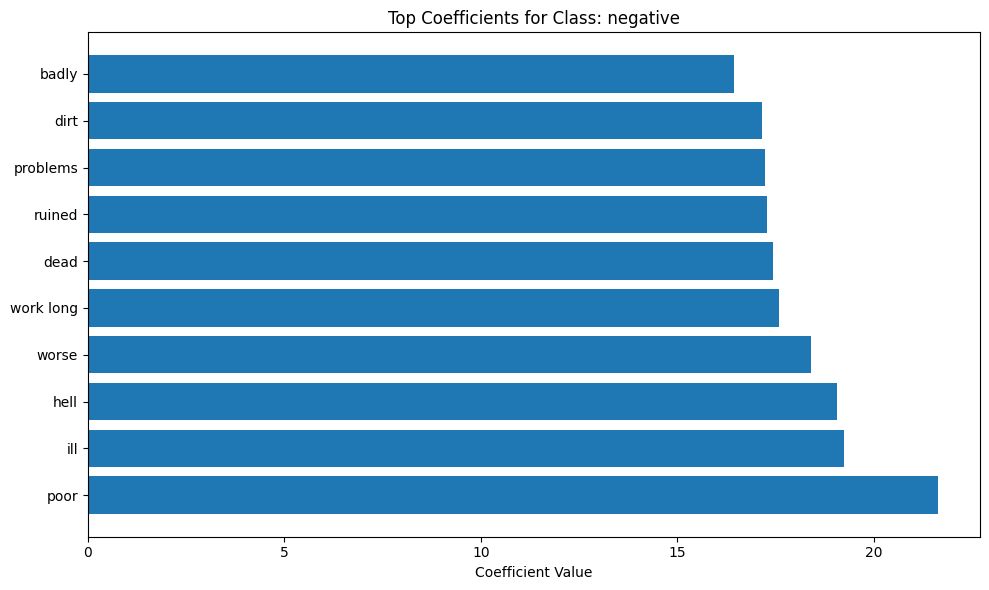

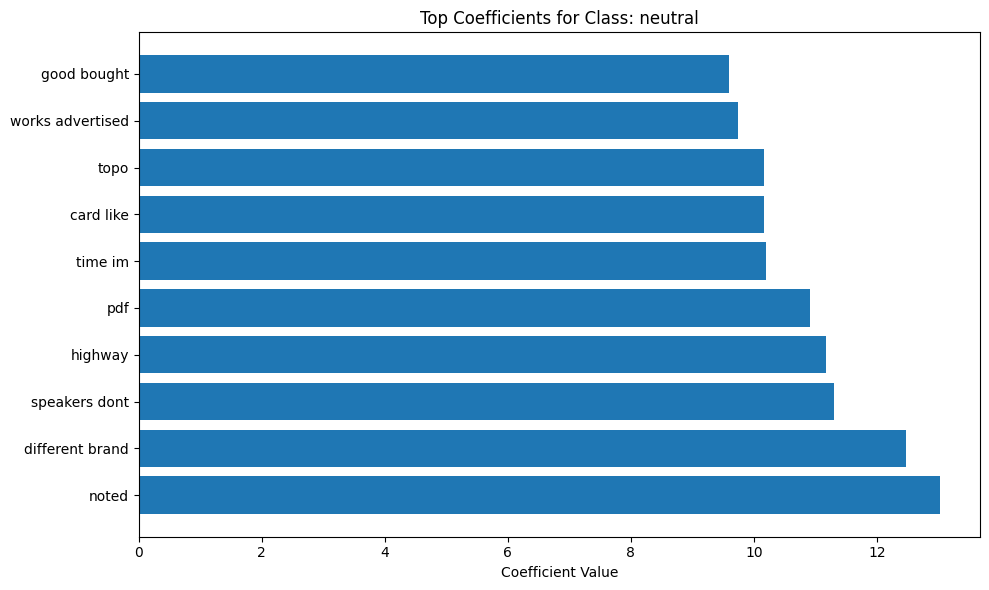

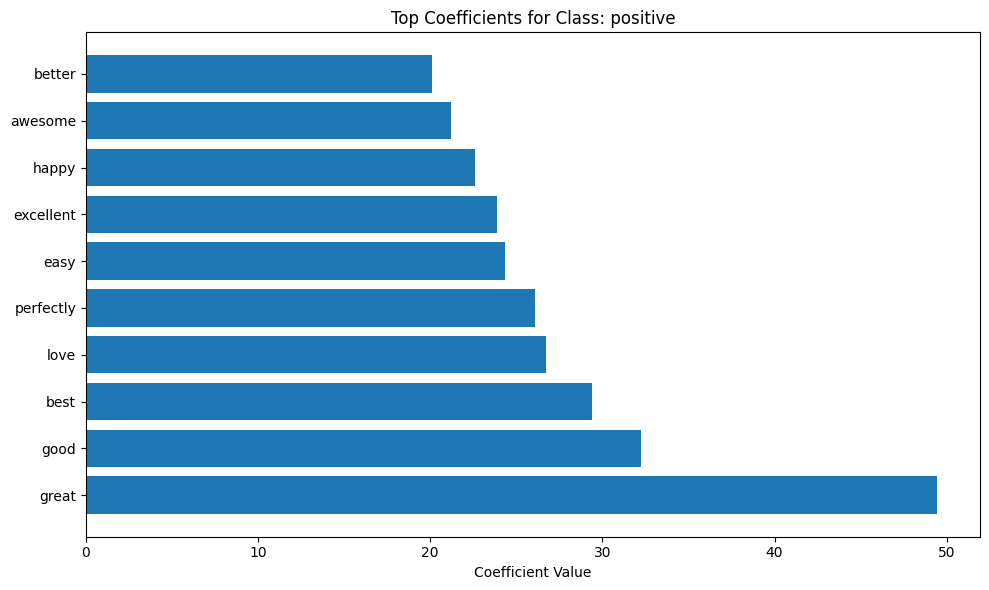


Model training and evaluation completed!


In [146]:
models = [
    ("Logistic Regression (Baseline)", baseline_results['accuracy']),
    ("Logistic Regression (Tuned)", lr_results['accuracy']),
    ("Random Forest (Baseline)", rf_baseline_results['accuracy']),
    ("Random Forest (Tuned)", rf_results['accuracy'])
]

# Create comparison bar chart
plt.figure(figsize=(12, 6))
models_df = pd.DataFrame(models, columns=['Model', 'Accuracy'])
ax = sns.barplot(x='Model', y='Accuracy', data=models_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=15)

# Add accuracy labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print comparison table
print("\nModel Comparison:")
comparison_df = pd.DataFrame({
    'Model': [m[0] for m in models],
    'Accuracy': [m[1] for m in models]
}).sort_values('Accuracy', ascending=False)
print(comparison_df)

# Feature importance for the best model (if Random Forest performs better)
if rf_results['accuracy'] > lr_results['accuracy']:
    print("\nRandom Forest Feature Importance:")
    
    # Load feature names
    with open('models/tfidf_feature_names.pkl', 'rb') as f:
        feature_names = pickle.load(f)
    
    # Get feature importance
    importances = rf_best.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances (Random Forest)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\nLogistic Regression Coefficients:")
    
    # For Logistic Regression, we can look at the coefficients
    with open('models/tfidf_feature_names.pkl', 'rb') as f:
        feature_names = pickle.load(f)
    
    # Get the coefficients
    if hasattr(lr_best, 'coef_'):
        # For binary classification
        if len(lr_best.classes_) == 2:
            coefs = lr_best.coef_[0]
            top_positive_indices = np.argsort(coefs)[-10:]
            top_negative_indices = np.argsort(coefs)[:10]
            
            plt.figure(figsize=(12, 8))
            plt.subplot(1, 2, 1)
            plt.title('Top Positive Coefficients')
            plt.barh(range(len(top_positive_indices)), coefs[top_positive_indices], align='center')
            plt.yticks(range(len(top_positive_indices)), [feature_names[i] for i in top_positive_indices])
            plt.xlabel('Coefficient Value')
            plt.gca().invert_yaxis()
            
            plt.subplot(1, 2, 2)
            plt.title('Top Negative Coefficients')
            plt.barh(range(len(top_negative_indices)), coefs[top_negative_indices], align='center')
            plt.yticks(range(len(top_negative_indices)), [feature_names[i] for i in top_negative_indices])
            plt.xlabel('Coefficient Value')
            plt.gca().invert_yaxis()
            
            plt.tight_layout()
            plt.show()
        # For multiclass
        else:
            for i, class_name in enumerate(lr_best.classes_):
                coefs = lr_best.coef_[i]
                top_indices = np.argsort(coefs)[-10:]
                
                plt.figure(figsize=(10, 6))
                plt.title(f'Top Coefficients for Class: {class_name}')
                plt.barh(range(len(top_indices)), coefs[top_indices], align='center')
                plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
                plt.xlabel('Coefficient Value')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.show()
                

print("\nModel training and evaluation completed!")

Save the result in a file

In [147]:
# Save the model comparison table to CSV
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("Model comparison results saved to 'model_comparison_results.csv'")

# Save the comparison bar chart
plt.figure(figsize=(12, 6))
models_df = pd.DataFrame(models, columns=['Model', 'Accuracy'])
ax = sns.barplot(x='Model', y='Accuracy', data=models_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
# Add accuracy labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
plt.tight_layout()
plt.savefig('model_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.close()
print("Model comparison chart saved to 'model_comparison_chart.png'")

# Save detailed results dictionary to a pickle file
import pickle

# Create a dictionary with all the results
all_results = {
    'baseline_results': baseline_results,
    'lr_results': lr_results,
    'rf_baseline_results': rf_baseline_results,
    'rf_results': rf_results,
    'best_models': {
        'lr_best': lr_best,
        'rf_best': rf_best
    },
    'comparison': comparison_df.to_dict()
}

# Save to pickle file
with open('all_model_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)
print("All model results saved to 'all_model_results.pkl'")

# Save feature importance/coefficients visualization
if rf_results['accuracy'] > lr_results['accuracy']:
    # Random Forest feature importance
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances (Random Forest)')
    importances = rf_best.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Random Forest feature importance chart saved to 'rf_feature_importance.png'")
else:
    # Logistic Regression coefficients
    if hasattr(lr_best, 'coef_'):
        if len(lr_best.classes_) == 2:
            # Binary classification
            coefs = lr_best.coef_[0]
            top_positive_indices = np.argsort(coefs)[-10:]
            top_negative_indices = np.argsort(coefs)[:10]
            
            plt.figure(figsize=(12, 8))
            plt.subplot(1, 2, 1)
            plt.title('Top Positive Coefficients')
            plt.barh(range(len(top_positive_indices)), coefs[top_positive_indices], align='center')
            plt.yticks(range(len(top_positive_indices)), [feature_names[i] for i in top_positive_indices])
            plt.xlabel('Coefficient Value')
            plt.gca().invert_yaxis()
            
            plt.subplot(1, 2, 2)
            plt.title('Top Negative Coefficients')
            plt.barh(range(len(top_negative_indices)), coefs[top_negative_indices], align='center')
            plt.yticks(range(len(top_negative_indices)), [feature_names[i] for i in top_negative_indices])
            plt.xlabel('Coefficient Value')
            plt.gca().invert_yaxis()
            
            plt.tight_layout()
            plt.savefig('lr_coefficients.png', dpi=300, bbox_inches='tight')
            plt.close()
            print("Logistic Regression coefficients chart saved to 'lr_coefficients.png'")
        else:
            # Multiclass
            for i, class_name in enumerate(lr_best.classes_):
                coefs = lr_best.coef_[i]
                top_indices = np.argsort(coefs)[-10:]
                
                plt.figure(figsize=(10, 6))
                plt.title(f'Top Coefficients for Class: {class_name}')
                plt.barh(range(len(top_indices)), coefs[top_indices], align='center')
                plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
                plt.xlabel('Coefficient Value')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.savefig(f'lr_coefficients_class_{class_name}.png', dpi=300, bbox_inches='tight')
                plt.close()
            print("Logistic Regression coefficients charts saved for each class")

# Save a summary text file with key findings
with open('model_summary.txt', 'w') as f:
    f.write("TEXT CLASSIFICATION MODEL RESULTS\n")
    f.write("===============================\n\n")
    f.write("MODEL ACCURACY COMPARISON:\n")
    f.write(comparison_df.to_string(index=False))
    f.write("\n\n")
    
    # Best model information
    best_model_name = comparison_df.iloc[0]['Model']
    best_model_accuracy = comparison_df.iloc[0]['Accuracy']
    f.write(f"BEST MODEL: {best_model_name} (Accuracy: {best_model_accuracy:.4f})\n\n")
    
    # Add hyperparameters of best models
    f.write("BEST MODEL HYPERPARAMETERS:\n")
    if "Logistic Regression" in best_model_name:
        f.write("Logistic Regression:\n")
        for param, value in lr_best.get_params().items():
            f.write(f"- {param}: {value}\n")
    else:
        f.write("Random Forest:\n")
        for param, value in rf_best.get_params().items():
            f.write(f"- {param}: {value}\n")

print("Model summary saved to 'model_summary.txt'")

Model comparison results saved to 'model_comparison_results.csv'
Model comparison chart saved to 'model_comparison_chart.png'
All model results saved to 'all_model_results.pkl'
Logistic Regression coefficients charts saved for each class
Model summary saved to 'model_summary.txt'
